In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [2]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-ccard-remote'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code DUGPL7QY3 to authenticate.
Interactive authentication successfully completed.


,
SDK version,1.0.83
Subscription ID,226fe521-cef6-4055-815e-bcd6cb72e514
Workspace,kaggle
Resource Group,rohan
Location,northeurope
Experiment Name,automl-classification-ccard-remote


In [3]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your AmlCompute cluster.
amlcompute_cluster_name = "cpu-cluster-1"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'cpu-cluster-1':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_DS12_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

# For a more detailed view of current AmlCompute status, use get_status().

Creating a new compute target...
Checking cluster status...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [4]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = 'Class'

In [5]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'average_precision_score_weighted',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2, # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_hours": 0.25, # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

In [6]:
remote_run = experiment.submit(automl_config, show_output = False)

In [7]:
# If you need to retrieve a run that already started, use the following code
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

In [8]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-ccard-remote,AutoML_9b09ab45-6382-45e1-b2ee-eef5616af105,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [9]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [10]:
remote_run.wait_for_completion(show_output=False)

{'runId': 'AutoML_9b09ab45-6382-45e1-b2ee-eef5616af105',
 'target': 'cpu-cluster-1',
 'status': 'Completed',
 'startTimeUtc': '2020-03-14T12:10:22.777918Z',
 'endTimeUtc': '2020-03-14T12:28:41.236529Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'average_precision_score_weighted',
  'train_split': '0',
  'MaxTimeSeconds': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster-1',
  'RawAMLSettingsString': "{'name': 'automl-classification-ccard-remote', 'path': None, 'subscription_id': '226fe521-cef6-4055-815e-bcd6cb72e514', 'resource_group': 'rohan', 'workspace_name': 'kaggle', 'region': 'northeurope', 'compute_target': 'cpu-cluster-1', 'spark_service': None, 'azure_service': None, 'iterations': 1000, 'primary_metric': 'average_precision_score_weighted', 'task_type': 'classification', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': 3, 'y_min': Non

In [11]:
best_run, fitted_model = remote_run.get_output()
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('7', PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('LightGB...form=None,
               weights=[0.5714285714285714, 0.35714285714285715, 0.07142857142857142]))]},
               y_transformer={}, y_transformer_name='LabelEncoder')

In [12]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()


In [13]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([False, False, False, ..., False, False, False])

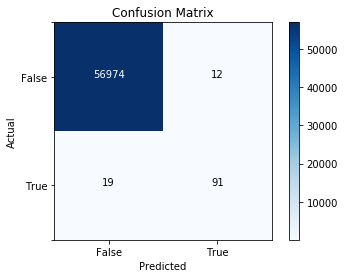

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()